In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import shutil

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image

In [44]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

### Background
In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).
### Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## Data Inspection

In [16]:
# Import data
df = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [17]:
df["label"].unique()

array([0, 1])

Based on the data inspection, the id represents image tag while the label is a boolean value indicating whether the image contains cancer or not. The images are 96x96 pixels in size and are stored in the .tif format.
Therefore, this problem involves a simple binary classification problem where the goal is to classify whether the image contains cancer or not.

To evaluate the model, the area under the ROC curve will be used.

## Exploratory Data Analysis

In [18]:
# Image sample size, for train/test data
print(len(os.listdir('histopathologic-cancer-detection/train')))
print(len(os.listdir('histopathologic-cancer-detection/test')))

220025
57458


In [19]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

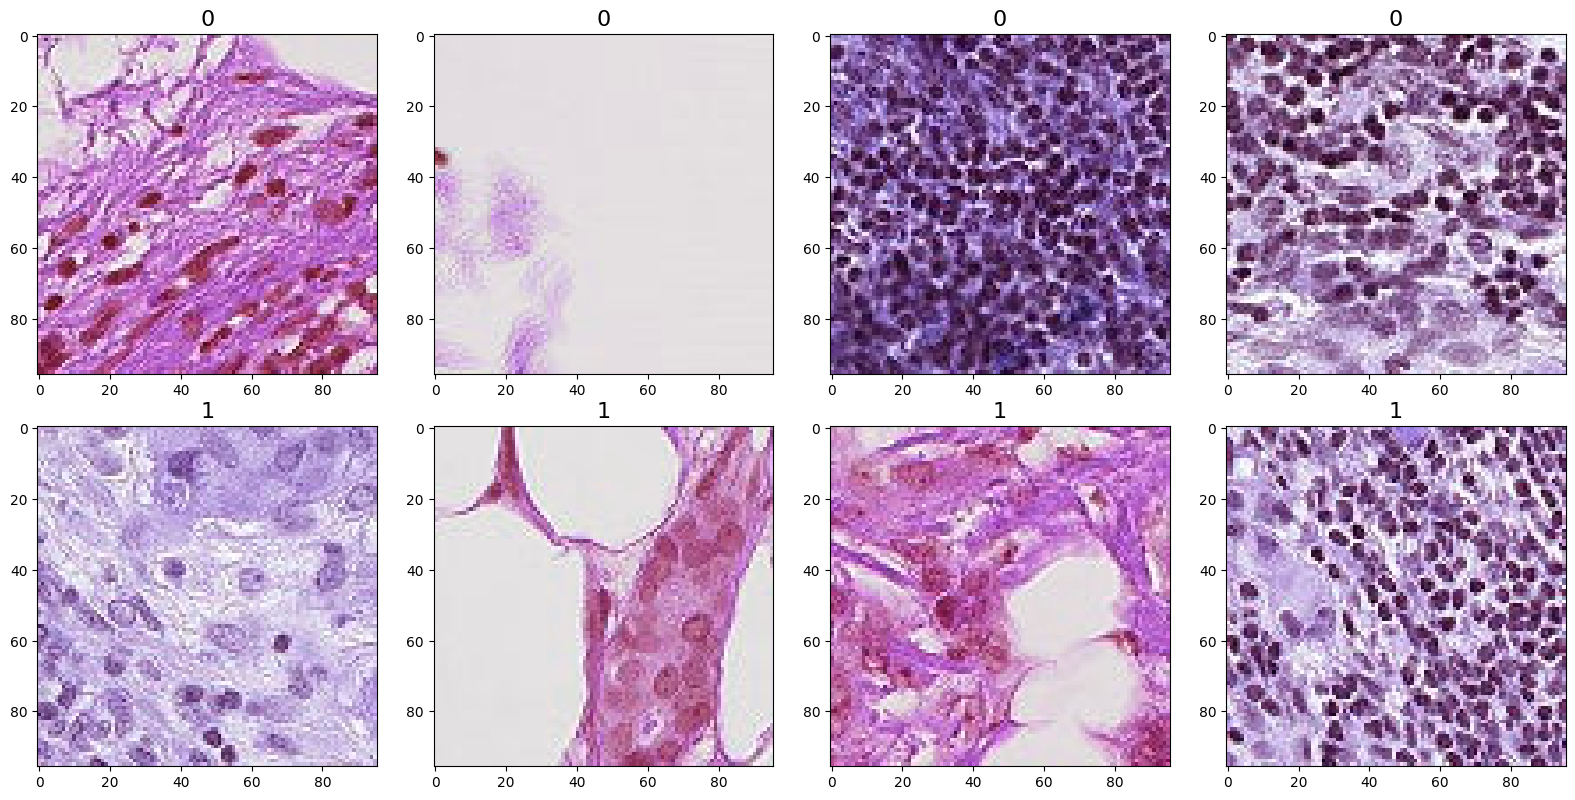

In [20]:
# Sample images
IMAGE_PATH = 'histopathologic-cancer-detection/train/' 

draw_category_images('label',4, df, IMAGE_PATH)

In [21]:
# Check any missing data
print(df.isnull().sum())
# Check duplicated data
print(df.duplicated().sum())

id       0
label    0
dtype: int64
0


The data set for labels have no missing or duplicated values.

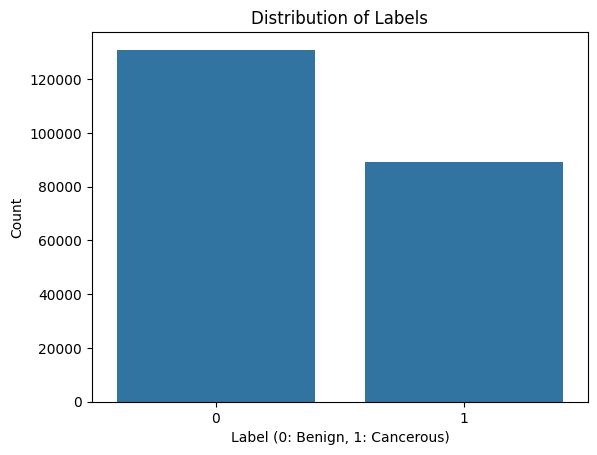

In [22]:
# Plot distribution of labels
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels')
plt.xlabel('Label (0: Benign, 1: Cancerous)')
plt.ylabel('Count')
plt.show()

From histogram, we can see there is no class imbalance in this dataset.

Based on the above, we can perform a simple binary classification model to classify whether the image contains cancer or not.

In [23]:
# Split data into train and test, by shuffling the data

df_0=df[df['label']==0].sample(80000, random_state=420)
df_1=df[df['label']==1].sample(80000, random_state=420)

df = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df = shuffle(df)

df['label'].value_counts()

label
0    80000
1    80000
Name: count, dtype: int64

In [24]:
df_train, df_val = train_test_split(df, test_size=0.20, random_state=420, stratify=df['label'])

print(df_train.shape)
print(df_val.shape)

(128000, 2)
(32000, 2)


In [25]:
df.head()

,id,label
33388,47052cadab178cd34c272208198f4c5088b22c35,0
104417,4b32640b28b5d6f3e106e17523643d7c5f67f999,1
48988,04357e2ec0b5be77463b50f83a95e8e9704a8fb5,0
89853,132173df1f713884bf35e20a2135765ea78d6d6a,1
58963,0f9819ac4986f0419c70efb04262de1c6101cc3c,0


In [26]:
df.set_index('id', inplace=True)

## Model Architecture

The model architecture will be a simple CNN model with the following layers:
- Conv2D layer with 32 filters, kernel size of 3x3, and ReLU activation function
- MaxPooling2D layer with pool size of 2x2
- Conv2D layer with 64 filters, kernel size of 3x3, and ReLU activation function
- MaxPooling2D layer with pool size of 2x2
- Conv2D layer with 128 filters, kernel size of 3x3, and ReLU activation function
- MaxPooling2D layer with pool size of 2x2
- Flatten layer
- Dense layer with 128 units and ReLU activation function
- Dense layer with 1 unit and sigmoid activation function

The model will be compiled with the binary crossentropy loss function and the Adam optimizer.


In [33]:
IMAGE_SIZE=96
IMAGE_CHANNELS=3

def cnn_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model

model = cnn_model()

## Image Preparation

Created directory for image data for classifying whether the image contains cancer or not. Transfer images into them.

In [28]:
train_list = list(df_train['id'])
val_list = list(df_val['id'])

for image in train_list:
    fname = image + '.tif'
    target = df.loc[image,'label']
    if target == 1:
        label = 'true'
    if target == 0:
        label = 'false'
    
    src = os.path.join('histopathologic-cancer-detection/train', fname)
    dst = os.path.join('histopathologic-cancer-detection/train_dir/', label, fname)

    shutil.copyfile(src, dst)

for image in val_list:
    fname = image + '.tif'
    target = df.loc[image,'label']
    if target == 1:
        label = 'true'
    if target == 0:
        label = 'false'
    src = os.path.join('histopathologic-cancer-detection/train', fname)
    dst = os.path.join('histopathologic-cancer-detection/val_dir/', label, fname)

    shutil.copyfile(src, dst)

In [29]:
# Check how many images are in the train_dir
print(len(os.listdir('histopathologic-cancer-detection/train_dir/true')))
print(len(os.listdir('histopathologic-cancer-detection/train_dir/false')))
print(len(os.listdir('histopathologic-cancer-detection/val_dir/true')))
print(len(os.listdir('histopathologic-cancer-detection/val_dir/false')))

79459
79474
39161
39128


In [30]:
train_path = 'histopathologic-cancer-detection/train_dir'
valid_path = 'histopathologic-cancer-detection/val_dir'
test_path = 'histopathologic-cancer-detection/test'
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10

train_steps = int(np.ceil(num_train_samples / train_batch_size))
val_steps = int(np.ceil(num_val_samples / val_batch_size))

In [34]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 158933 images belonging to 2 classes.
Found 78289 images belonging to 2 classes.
Found 78289 images belonging to 2 classes.


## Model Training

In [35]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,034 (6.61 MB)

 Trainable params: 1,732,034 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
val_gen.class_indices

{'false': 0, 'true': 1}

In [38]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 5505/15894 ━━━━━━━━━━━━━━━━━━━━ 7:45 45ms/step - accuracy: 0.6140 - loss: 0.6469

KeyboardInterrupt: 

## Model Evaluation

In [ ]:
model.metrics_names

In [ ]:
# Best Epoch
val_loss, val_acc = model.evaluate_generator(test_gen, steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

In [ ]:
# Evaluation Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()